<a href="https://colab.research.google.com/github/jcwright77/fig2h5/blob/main/Copy_of_plot_to_hdf5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Exploring how to export plot data structure for reproducible data.

john wright <jcwright@mit.edu>

In [45]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.__version__,np.__version__

('3.2.2', '1.21.6')

In [46]:
!pip install nexusformat h5glance
import nexusformat.nexus as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
def fig2h5(name,fig,md,info=True,**args):
    import matplotlib.pyplot as plt
    import numpy as np
    import h5py
    
    axhdl=fig.axes
    
    #logic to get axis if just list of one axis [as returned by fig.get_axes() ]
    if str(type(axhdl))=="<class 'list'>":
        if len(axhdl)==1:
            axhdl=axhdl[0]
    
    hf = h5py.File(name+'.h5', 'a')

    hf.attrs.update(md)
    
    grp1 = hf.create_group("data")
    if info : print('group', grp1.name)

    if str(type(axhdl))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
        AxesSubplot2h5(grp1, fig, axhdl, info, **args )
    
    elif str(type(axhdl))=="<class 'numpy.ndarray'>" or str(type(axhdl))=="<class 'list'>":
        if info: print('fig2h5 subfigure call') 
        Subfigures2h5(grp1, fig, axhdl, info, **args)
        
    elif str(type(axhdl))=="<class 'matplotlib.axes._subplots.Axes3DSubplot'>":
        Axes3DSubplot2h5(grp1, fig, axhdl, info, **args)
        
    
    hf.close()
    
    

def AxesSubplot2h5(topgrp,fig,axhdl,info,**args):
    """
    Handler for one dim plots possibly with multiple lines and 
    redirection for histograms
    """ 

    grp1 = topgrp.create_group("plot")
    if len(axhdl.containers)!=0:
        print('fig2h5 histogram call') 
        AxesHistogram2h5(grp1,fig,axhdl,info, **args)
        return
    
    if info : print('group', grp1.name)
    grp1.attrs['plotposition']=np.array(axhdl.get_position())
    grp1.attrs['title']=axhdl.title.get_text()
    grp1.attrs['xlabel']=axhdl.xaxis.label.get_text()
    grp1.attrs['ylabel']=axhdl.yaxis.label.get_text()

    nplots=len(axhdl.lines)
    for i in range(nplots):
        if info: print('AxesSubplot2h5 loop: nlines, index', nplots, i)
        l1=axhdl.lines[i]
        dset = grp1.create_dataset('linex'+str(i+1), 
                                  data=l1.get_xdata())
        dset = grp1.create_dataset('liney'+str(i+1), 
                                  data=l1.get_ydata())
        dset.attrs['linecolor']=l1.get_color()
        dset.attrs['linewidth']=l1.get_linewidth()
        dset.attrs['markertype']=l1.get_marker()
        dset.attrs['markercolor']=l1.get_markerfacecolor()



def Subfigures2h5(topgrp,fig,axhdl,info,**args):
    """
    Handler for plots with multiple panels (subfigures).
    """ 
    
    nplots=np.array(axhdl).size
    grp0 = topgrp.create_group("plotgrid"+str(nplots))
    if info : print('group', grp0.name)

    maintitle=fig._suptitle
    if maintitle: 
        grp0.attrs['title']=maintitle.get_text()
    
    if info: print('subfig nplots',nplots)
    for ix in range(nplots):
        grp1 = grp0.create_group("plot"+str(ix+1)+'of'+str(nplots) )
        if info : print('group', grp1.name)
        ax=np.array(axhdl).flatten()[ix]
        if info : print('Subfigures',ix+1,'ax type', str(type(ax)))
        if str(type(ax))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
            AxesSubplot2h5(grp1, fig, ax, info, **args)
        elif str(type(ax))=="<class 'numpy.ndarray'>" or str(type(axhdl))=="<class 'list'>":
            AxesHistogram2h5(grp1, fig, ax, info, **args)
            
            
    

def Axes3DSubplot2h5(topgrp,fig,axhdl,info,**args):
    """
    Handler for three dim plots possibly with multiple lines
    """ 
    grp1 = topgrp.create_group("plot")
    if info : print('group', grp1.name)
    grp1.attrs['plotposition']=np.array(axhdl.get_position())
    grp1.attrs['title']=axhdl.title.get_text()
    grp1.attrs['xlabel']=axhdl.xaxis.label.get_text()
    grp1.attrs['ylabel']=axhdl.yaxis.label.get_text()

    d = ax.collections
    nplots=len(d)
    if info: print('Axes3DSubplot2h5', nplots)
    for i in range(nplots):
        if info: print('Axes3DSubplot2h5', nplots, i)
        dset = grp1.create_dataset('points3d'+str(i+1), 
                                  data=np.array(d[i]._offsets3d).T)
        dset.attrs['markercolor']=d[i].get_facecolor()[-1][0:3]

        

def AxesHistogram2h5(topgrp,fig,axhdl,info,**args):
    """
    Handler for histograms
    """ 
    import numpy as np
    
    grp1 = topgrp.create_group("plot")
    if info : print('group', grp1.name)
    grp1.attrs['plotposition']=np.array(axhdl.get_position())
    grp1.attrs['title']=axhdl.title.get_text()
    grp1.attrs['xlabel']=axhdl.xaxis.label.get_text()
    grp1.attrs['ylabel']=axhdl.yaxis.label.get_text()

    d = axhdl.containers #https://matplotlib.org/3.1.1/api/container_api.html
    #https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Rectangle.html#matplotlib.patches.Rectangle

    nsets=len(d)
    if info: print('Axes3DSubplot2h5', nsets)
    for i in range(nsets):
        if info: print('Axes3DSubplot2h5 nsets', nsets, i)
        rsw=[] ; rsxy=[] ; rsdv=[] 
        for j,rect in enumerate(d[i].get_children()):
            if info: print('Axes3DSubplot2h5 rect', j)
            rsxy.append( rect.xy )
            rsw.append(  rect.get_width()  )
            rsdv.append( rect.get_height() ) #datavalues[j])
        dset = grp1.create_dataset('bins_xy'+str(i+1), data=np.array(rsxy) )
        dset = grp1.create_dataset('bins_width'+str(i+1), data=np.array(rsw) )
        dset = grp1.create_dataset('bins_height'+str(i+1), data=np.array(rsdv) )
        dset.attrs['markercolor']=rect.get_facecolor()[0:3]
        if 'rawdata' in args:
            rd = args['rawdata']
            dset = grp1.create_dataset('rawdata'+str(i+1), data=rd)
       


### line plot

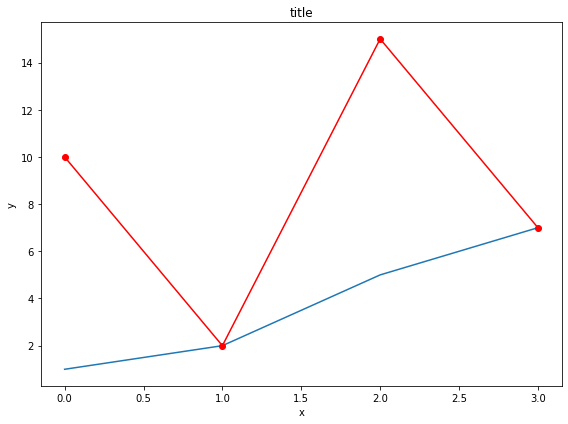

In [48]:
fig1,ax1 = plt.subplots(figsize=(8, 6),tight_layout=True)
ax1.plot([1,2,5,7]);
ax1.plot([10,2,15,7],'-ro');
ax1.set_xlabel('x')
ax1.set_title('title')
ax1.set_ylabel('y');

In [49]:
from datetime import date
md = {
    "title" : "",
    "authors" : [],
    "published" : str(date.fromisoformat('2022-07-01')),
    "journal" : "Journal of Plasma Physics",
    "volume": "",
    "page": "",
    "DOI" : "",
    "caption" : "Figure ",
    "creation-date" : str(date.today())
}

In [50]:
str(date.today()),str(date.fromisoformat('2022-07-01'))

('2022-09-09', '2022-07-01')

caption in metadata should be updated for each file/figure.

In [51]:
def h5py_dataset_iterator(g, prefix=''):
    for key, item in g.items():
        path = '{}/{}'.format(prefix, key)
        if isinstance(item, h5py.Dataset): # test for dataset
            yield (path, item)
        elif isinstance(item, h5py.Group): # test for group (go down)
            yield from h5py_dataset_iterator(item, path)


In [52]:
!rm a.h5

In [53]:
import copy
 
md1=copy.deepcopy(md)
md1['caption']='test figure 1 line plots'
fig2h5('a',fig1, md1)

group /data
group /data/plot
AxesSubplot2h5 loop: nlines, index 2 0
AxesSubplot2h5 loop: nlines, index 2 1


In [54]:
import h5py
def h5dump(fname):
  with h5py.File(fname, 'r') as f:
    for (path, dset) in h5py_dataset_iterator(f):
        print(path, dset)
    for name in f:
      print(name)
    print(f.attrs.keys())
    print(f.items())
    

In [57]:
h5dump('a.h5')

/data/plot/linex1 <HDF5 dataset "linex1": shape (4,), type "<f8">
/data/plot/linex2 <HDF5 dataset "linex2": shape (4,), type "<f8">
/data/plot/liney1 <HDF5 dataset "liney1": shape (4,), type "<i8">
/data/plot/liney2 <HDF5 dataset "liney2": shape (4,), type "<i8">
data
<KeysViewHDF5 ['DOI', 'authors', 'caption', 'creation-date', 'journal', 'page', 'published', 'title', 'volume']>
ItemsViewHDF5(<HDF5 file "a.h5" (mode r)>)


In [58]:
!h5glance a.h5

a.h5 (9 attributes)
└data
  └plot (4 attributes)
    ├linex1	[float64: 4]
    ├linex2	[float64: 4]
    ├liney1	[int64: 4] (4 attributes)
    └liney2	[int64: 4] (4 attributes)



In [72]:
from h5glance import H5Glance

import h5glance
h5glance.install_ipython_h5py_display()


In [76]:
f=h5py.File('a.h5', 'r')
f

a.h5/ (9 attributes)
└data	(1 children)

In [78]:
H5Glance(f)

a.h5/ (9 attributes)
└data	(1 children)

In [75]:
f.close()

### Subplots test

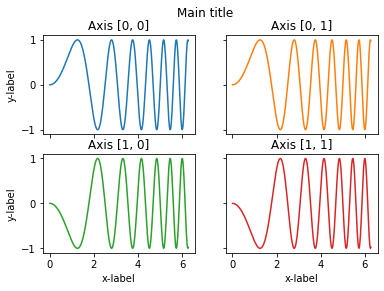

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)
fig4, axs = plt.subplots(2, 2)
fig4.suptitle('Main title')
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


In [ ]:
!rm a.h5

fig2h5('a',fig4, md, info=False)

#!h5dump a.h5

In [ ]:
h5dump('a.h5')

/data/plotgrid4/plot1of4/plot/linex1 <HDF5 dataset "linex1": shape (400,), type "<f8">
/data/plotgrid4/plot1of4/plot/liney1 <HDF5 dataset "liney1": shape (400,), type "<f8">
/data/plotgrid4/plot2of4/plot/linex1 <HDF5 dataset "linex1": shape (400,), type "<f8">
/data/plotgrid4/plot2of4/plot/liney1 <HDF5 dataset "liney1": shape (400,), type "<f8">
/data/plotgrid4/plot3of4/plot/linex1 <HDF5 dataset "linex1": shape (400,), type "<f8">
/data/plotgrid4/plot3of4/plot/liney1 <HDF5 dataset "liney1": shape (400,), type "<f8">
/data/plotgrid4/plot4of4/plot/linex1 <HDF5 dataset "linex1": shape (400,), type "<f8">
/data/plotgrid4/plot4of4/plot/liney1 <HDF5 dataset "liney1": shape (400,), type "<f8">
data
<KeysViewHDF5 ['DOI', 'authors', 'caption', 'creation-date', 'journal', 'page', 'published', 'title', 'volume']>
ItemsViewHDF5(<HDF5 file "a.h5" (mode r)>)


### 3D scatter plot test

28.566143494121537 57.644633725445345 -9.834090016125714


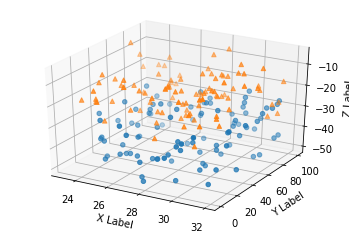

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig3d = plt.figure()
ax = fig3d.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
print(xs[0],ys[0],zs[0])
plt.show()

In [ ]:
!rm 3d.h5

fig2h5('3d',fig3d, md)

!h5dump 3d.h5
h5dump("3d.h5")

rm: cannot remove '3d.h5': No such file or directory
group /data
group /data/plot
Axes3DSubplot2h5 2
Axes3DSubplot2h5 2 0
Axes3DSubplot2h5 2 1
/bin/bash: h5dump: command not found
/data/plot/points3d1 <HDF5 dataset "points3d1": shape (100, 3), type "<f8">
/data/plot/points3d2 <HDF5 dataset "points3d2": shape (100, 3), type "<f8">
data
<KeysViewHDF5 ['DOI', 'authors', 'caption', 'creation-date', 'journal', 'page', 'published', 'title', 'volume']>
ItemsViewHDF5(<HDF5 file "3d.h5" (mode r)>)


In [ ]:
ax.collections[0].properties()

{'agg_filter': None,
 'alpha': None,
 'animated': False,
 'array': None,
 'capstyle': None,
 'children': [],
 'clim': (None, None),
 'clip_box': <matplotlib.transforms.TransformedBbox at 0x7f440c95fc50>,
 'clip_on': True,
 'clip_path': None,
 'cmap': <matplotlib.colors.ListedColormap at 0x7f441a979fd0>,
 'contains': None,
 'edgecolor': array([[0.12156863, 0.46666667, 0.70588235, 0.47249699],
        [0.12156863, 0.46666667, 0.70588235, 0.65151455],
        [0.12156863, 0.46666667, 0.70588235, 0.84456021],
        [0.12156863, 0.46666667, 0.70588235, 0.59928273],
        [0.12156863, 0.46666667, 0.70588235, 0.5592641 ],
        [0.12156863, 0.46666667, 0.70588235, 0.50718744],
        [0.12156863, 0.46666667, 0.70588235, 0.54159484],
        [0.12156863, 0.46666667, 0.70588235, 0.64783527],
        [0.12156863, 0.46666667, 0.70588235, 0.76093438],
        [0.12156863, 0.46666667, 0.70588235, 0.48521072],
        [0.12156863, 0.46666667, 0.70588235, 0.58858056],
        [0.12156863, 0.46

## Histogram

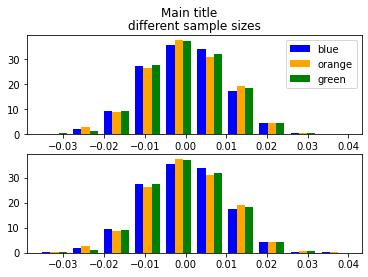

In [ ]:
fighist, axh = plt.subplots(2, 1)
fighist.suptitle('Main title')

#fighist,axh= plt.subplots(figsize=(8, 6),tight_layout=True)

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)/100

axh[0].set_title('different sample sizes')
#axh.set_title('different sample sizes')

#print(str(type(axh)))
          
colors = ['blue', 'orange', 'green']

#counts,bins,bars=axh.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
counts,bins,bars=axh[0].hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
counts,bins,bars=axh[1].hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)

axh[0].legend(prop={'size': 10})
#axh.legend(prop={'size': 10})

plt.show()

In [ ]:
!rm histdata.h5

In [ ]:
fig2h5('histdata',fighist,md,info=True) #,rawdata=x)

group /data
fig2h5 subfigure call
group /data/plotgrid2
subfig nplots 2
group /data/plotgrid2/plot1of2
Subfigures 1 ax type <class 'matplotlib.axes._subplots.AxesSubplot'>
fig2h5 histogram call
group /data/plotgrid2/plot1of2/plot/plot
Axes3DSubplot2h5 3
Axes3DSubplot2h5 nsets 3 0
Axes3DSubplot2h5 rect 0
Axes3DSubplot2h5 rect 1
Axes3DSubplot2h5 rect 2
Axes3DSubplot2h5 rect 3
Axes3DSubplot2h5 rect 4
Axes3DSubplot2h5 rect 5
Axes3DSubplot2h5 rect 6
Axes3DSubplot2h5 rect 7
Axes3DSubplot2h5 rect 8
Axes3DSubplot2h5 rect 9
Axes3DSubplot2h5 nsets 3 1
Axes3DSubplot2h5 rect 0
Axes3DSubplot2h5 rect 1
Axes3DSubplot2h5 rect 2
Axes3DSubplot2h5 rect 3
Axes3DSubplot2h5 rect 4
Axes3DSubplot2h5 rect 5
Axes3DSubplot2h5 rect 6
Axes3DSubplot2h5 rect 7
Axes3DSubplot2h5 rect 8
Axes3DSubplot2h5 rect 9
Axes3DSubplot2h5 nsets 3 2
Axes3DSubplot2h5 rect 0
Axes3DSubplot2h5 rect 1
Axes3DSubplot2h5 rect 2
Axes3DSubplot2h5 rect 3
Axes3DSubplot2h5 rect 4
Axes3DSubplot2h5 rect 5
Axes3DSubplot2h5 rect 6
Axes3DSubplot2h5 

In [ ]:
h5dump('histdata.h5')

/data/plotgrid2/plot1of2/plot/plot/bins_height1 <HDF5 dataset "bins_height1": shape (10,), type "<f8">
/data/plotgrid2/plot1of2/plot/plot/bins_height2 <HDF5 dataset "bins_height2": shape (10,), type "<f8">
/data/plotgrid2/plot1of2/plot/plot/bins_height3 <HDF5 dataset "bins_height3": shape (10,), type "<f8">
/data/plotgrid2/plot1of2/plot/plot/bins_width1 <HDF5 dataset "bins_width1": shape (10,), type "<f8">
/data/plotgrid2/plot1of2/plot/plot/bins_width2 <HDF5 dataset "bins_width2": shape (10,), type "<f8">
/data/plotgrid2/plot1of2/plot/plot/bins_width3 <HDF5 dataset "bins_width3": shape (10,), type "<f8">
/data/plotgrid2/plot1of2/plot/plot/bins_xy1 <HDF5 dataset "bins_xy1": shape (10, 2), type "<f8">
/data/plotgrid2/plot1of2/plot/plot/bins_xy2 <HDF5 dataset "bins_xy2": shape (10, 2), type "<f8">
/data/plotgrid2/plot1of2/plot/plot/bins_xy3 <HDF5 dataset "bins_xy3": shape (10, 2), type "<f8">
/data/plotgrid2/plot2of2/plot/plot/bins_height1 <HDF5 dataset "bins_height1": shape (10,), type "

In [79]:
f = nx.nxload('histdata.h5')
print(f.tree)

root:NXroot
  @DOI = 'doi:10.1017/S0022377822000708'
  @authors = ['G.W. Wallace', 'Z. Bai', 'R. Sadre', 'T. Per...
  @caption = 'Figure'
  @creation-date = '2022-09-09'
  @journal = 'Journal of Plasma Physics'
  @page = '895880401'
  @published = '2022-07-01'
  @title = 'Towards Fast and Accurate Predictions of Radio...'
  @volume = '88'
  data:NXgroup
    plotgrid2:NXgroup
      @title = 'Main title'
      plot1of2:NXgroup
        plot:NXgroup
          plot:NXgroup
            @plotposition = [[0.125    0.536818]...
            @title = 'different sample sizes'
            @xlabel = ''
            @ylabel = ''
            bins_height1 = float64(10)
              @markercolor = [0. 0. 1.]
            bins_height2 = float64(10)
              @markercolor = [1.       0.647059 0.      ]
            bins_height3 = float64(10)
              @markercolor = [0.       0.501961 0.      ]
            bins_width1 = float64(10)
            bins_width2 = float64(10)
            bins_width3 = floa

In [82]:
ff=h5py.File('histdata.h5', 'r')
ff

histdata.h5/ (9 attributes)
└data	(1 children)